### Aprendizaje automático II. Pytorch
___

#### Exercise 1
---

Redefine the model to be `w2*t_u**3 + w1*t_u + b`

In [7]:
import torch 

def model(t_u, w2, w1, b):
    return w2*t_u**2 + w1*t_u + b

def loss_fn(t_p, t_c):
    return ((t_p - t_c)**2).mean()

def split(t_u, t_c, val_size=0.2):
    n = t_u.size()[0]  # dataset size
    indices = torch.randperm(n) # shuffle indices
    p = int(val_size * n)  # partition index
    
    # training set
    t_train_u = t_u[indices[:-p]] 
    t_train_c = t_c[indices[:-p]]
    
    # validation set
    t_val_u = t_u[indices[-p:]]  
    t_val_c = t_c[indices[-p:]]
    
    return t_train_u, t_train_c, t_val_u, t_val_c

def training_loop(n_epochs, optimizer, params, t_train_u, t_train_c, 
                  t_val_u, t_val_c, output=False, output_step=1):
    # loss and params per epoch registers
    t_loss_reg = torch.zeros(n_epochs)
    t_val_loss_reg = torch.zeros(n_epochs)
    t_params_reg = torch.zeros([n_epochs, params.size()[0]])
        
    for i in range(n_epochs):
        # training
        t_p = model(t_train_u, *params)
        loss = loss_fn(t_p, t_train_c)
    
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        t_loss_reg[i] = loss
        t_params_reg[i] = params
        
        # validation
        with torch.no_grad():
            t_p = model(t_val_u, *params)
            loss = loss_fn(t_p, t_val_c)
            t_val_loss_reg[i] = loss
            
        if output and i%output_step==0:
            print(f'Epoch: {i}, train_loss: {t_loss_reg[i].item():.3f}, val_loss: {t_val_loss_reg[i].item():.3f}')
    
    return t_loss_reg, t_val_loss_reg, t_params_reg

In [12]:
import torch.optim as optim

# temperaturas ºC
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]

# temperaturas en escala desconocida (unknown)
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

#t_c = torch.tensor(t_c, device='cuda')
#t_u = torch.tensor(t_u, device='cuda')
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

# split 
t_train_u, t_train_c, t_val_u, t_val_c = split(t_u, t_c)

# normalize
t_train_un = (t_train_u - t_train_u.mean())/t_train_u.std()
t_val_un = (t_val_u - t_val_u.mean())/t_val_u.std()

# initialize params
#params = torch.tensor([1., 1., 0.], requires_grad=True, device='cuda')
params = torch.tensor([1., 1., 0.], requires_grad=True)

# optimizer
learning_rate = 1e-2
optimizer = optim.Adam([params], lr=learning_rate)

# training loop
n_epochs = 5000
t_loss_reg, t_val_loss_reg, t_params_reg = training_loop(
    n_epochs=n_epochs, 
    optimizer=optimizer, 
    params=params, 
    t_train_u=t_train_u, 
    t_train_c=t_train_c,
    t_val_u=t_val_un, 
    t_val_c=t_val_c,
    output=True, output_step=500)

print(f"Loss - train: {t_loss_reg[-1]:.3f} validation: {t_val_loss_reg[-1]:.3f}")


Epoch: 0, train_loss: 12565346.000, val_loss: 101.425
Epoch: 500, train_loss: 6.158, val_loss: 136.934
Epoch: 1000, train_loss: 6.013, val_loss: 137.147
Epoch: 1500, train_loss: 5.809, val_loss: 137.456
Epoch: 2000, train_loss: 5.551, val_loss: 137.868
Epoch: 2500, train_loss: 5.244, val_loss: 138.392
Epoch: 3000, train_loss: 4.900, val_loss: 139.038
Epoch: 3500, train_loss: 4.534, val_loss: 139.811
Epoch: 4000, train_loss: 4.170, val_loss: 140.712
Epoch: 4500, train_loss: 3.836, val_loss: 141.729
Loss - train: 3.559 validation: 142.837


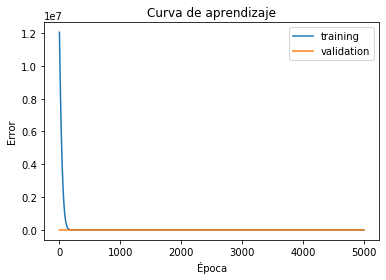

In [9]:
from matplotlib import pyplot as plt

# Plot error loss
plt.plot(t_loss_reg.detach().numpy(), label="training")
plt.plot(t_val_loss_reg, label="validation")
plt.title(f"Curva de aprendizaje")
plt.ylabel("Error")
plt.xlabel("Época")
plt.legend()
plt.show()


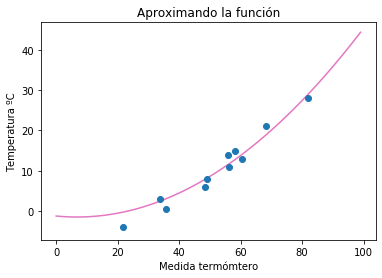

In [13]:
# plot model
x = torch.arange(0, 100).float()
t_p = model(x, *t_params_reg[-1])   

# si el training set estaba normalizado, tenemos que aplicar 
# el modelo sobre datos normalizados. SGD sí, Adam no
# x_n = (x - x.mean())/x.std()
# t_p = model(x_n, *t_params_reg[-1]) 

plt.plot(x, t_p.detach().numpy(), '#e377c2', zorder=1)
plt.scatter(t_u, t_c, zorder=2)
#plt.scatter(t_u.cpu(), t_c.cpu(), zorder=2)

plt.title("Aproximando la función")
plt.ylabel("Temperatura ºC")
plt.xlabel("Medida termómetro")
plt.show()